# Term Project  - Recurrent Autoencoder for IMDB Review Sentiment Classification

# My Table of content
- [1. Script Initialization](#initialization)
- [2. Data Load](#Dataload)
- [3. Base Model](#Basemodel)
- [4. Experiment 1: Using 1 or 3 hidden layers](#Exp1)
- [5. Experiment 2: Using 8 or 32 or 64 hidden units](#Exp2)
- [6. Experiment 3: Using MSE Loss](#Exp3)
- [7. Experiment 4: Using Tanh Activation](#Exp4)

## Import Necessary packages and define function  <div id='initialization'/>

### packages

In [3]:
#seed
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import random
random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


import keras
keras.__version__ 
import tensorflow as tf 
from keras import models
import h5py
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt 
from tensorflow import keras   
import numpy as np
import tensorflow.keras.backend as K
print(tf.keras.__version__)
import os, os.path, shutil
import time
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout 
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from os import path
import pandas as pd 
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import re
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from sklearn.manifold import TSNE

2.4.0


### Defined Functions

In [ ]:
# Plotting function -  Plot training performance
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history[metric])
  plt.plot(history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
# Rounded accuracy used for autoencoder training
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [6]:
# vecotize function for converting the reviews to one hot encoding for word occurences
def vectorize_sequences(sequences, dimension=1000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences): # enumerate applies index to each IMDB movie review of word indices.
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Import the Data File <div id='Dataload'/>

In [ ]:
Load the IMDB reviews importing only the top 1000 words similar to the RNN 

In [7]:

top_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
(all_X_train, _), (all_X_valid, _) = imdb.load_data() # For all review words

#Whole dataset by concating train and test
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

X_Valid, X_Test = X_test[:-5000], X_test[-5000:]
y_Valid, y_Test= y_test[:-5000], y_test[-5000:]

# Recurrent AutoEncoder Training set.
X_Train_RE = X_train[-7500:]  
y_Train_RE = y_train[-7500:] 

# Recurrent AutoEncoder Validation set.
X_Valid_RE = X_Valid[-1000:]  
y_Valid_RE = y_Valid[-1000:]  

(array([0, 1]), array([3800, 3700]))

In [9]:
# Summarize number of words
print("Number of unique words in whole data set: ")
print(len(np.unique(np.hstack(X))))
print("Number of unique words in training set: ")
print(len(np.unique(np.hstack(X_train))))
print("Number of unique words in validation set: ")
print(len(np.unique(np.hstack(X_Valid))))
print("Number of unique words in test set: ")
print(len(np.unique(np.hstack(X_Test))))
print("Number of unique words in the Recurrent AutoEncoder training set: ")
print(len(np.unique(np.hstack(X_Valid_RE))))
print("Number of unique words in Recurrent AutoEncoder validation set: ")
print(len(np.unique(np.hstack(X_Valid_RE))))

Number of unique words in whole data set: 
998
Number of unique words in training set: 
998
Number of unique words in validation set: 
998
Number of unique words in test set: 
998
Number of unique words in the Recurrent AutoEncoder training set: 
998
Number of unique words in Recurrent AutoEncoder validation set: 
998


In [10]:
print("Number of records in Whole dataset: " + str (X.shape))
print("Number of records in Train set: " + str (X_train.shape))
print("Number of records in Validation set: " + str (X_Valid.shape))
print("Number of records in Test set: " + str (X_Test.shape))
print("Number of records in Recurrent AutoEncoder training set: " + str (X_Train_RE.shape))
print("Number of records in Recurrent AutoEncoder validation set: " + str (X_Valid_RE.shape))
print("Classes: " + str(np.unique(y)))

Number of records in Whole dataset: (50000,)
Number of records in Train set: (25000,)
Number of records in Validation set: (20000,)
Number of records in Test set: (5000,)
Number of records in Recurrent AutoEncoder training set: (7500,)
Number of records in Recurrent AutoEncoder validation set: (1000,)
Classes: [0 1]


In [11]:
#  vectorized training data
X_train_vec = vectorize_sequences(X_train)
#  vectorized validation data
X_Valid_vec = vectorize_sequences(X_Valid)
#  vectorized test data
X_Test_vec = vectorize_sequences(X_Test)
# vectorized Recurrent AutoEncoder Training set.
X_Train_RE_vec = vectorize_sequences(X_Train_RE)
# vectorized Recurrent AutoEncoder validation set.
X_Valid_RE_vec = vectorize_sequences(X_Valid_RE)
 
    
# Our vectorized labels
y_Train_RE = np.asarray(y_Train_RE).astype('float32')
y_Valid_RE = np.asarray(y_Valid_RE).astype('float32')
y_Valid    = np.asarray(y_Valid).astype('float32') 
y_Test     = np.asarray(y_Test).astype('float32')
y_train    = np.asarray(y_train).astype('float32') 

When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each word intensity represents the probability that the word is less frequent. Framing it this way (rather than as a regression problem using MSE) tends to make the model converge faster according to the MLH textbook.

In [12]:
X_train_vec = X_train_vec.reshape(X_train_vec.shape[0], top_words, 1) 
X_Test_vec = X_Test_vec.reshape(X_Test_vec.shape[0], top_words, 1) 
X_Valid_vec = X_Valid_vec.reshape(X_Valid_vec.shape[0], top_words, 1) 
X_Train_RE_vec = X_Train_RE_vec.reshape(X_Train_RE_vec.shape[0], top_words, 1)
X_Valid_RE_vec = X_Valid_RE_vec.reshape(X_Valid_RE_vec.shape[0], top_words, 1) 

In [13]:
X_train_vec.shape

(25000, 1000, 1)

In [14]:
#X_Train_RE

# Create the Reconstruction LSTM Recurrent Autoencoder

In [15]:
# -look into tying the layers to reduce training time. Only seems to be applicable to the dense layer based on the literatire.
# - consider training as a sparse encoder. DONE
# -look into adding early stopping and model saving. DONE
# -compare the reconstruction to the input using example reviews or plot word index to reconstruction.
# -use t-SNE to visualize the encoder in a lower dimensional space.

In [ ]:

np.unique(y_Train_RE, return_counts=True) 

In [18]:
# Encoder
recurrent_encoder = keras.models.Sequential([ 
    keras.layers.LSTM(100,  return_sequences=True, #Tanh activiation for hidden layer. 
                      input_shape=[top_words,1]), #lower dim. from input return seq. to next layer.
    keras.layers.LSTM(75 ,  return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.LSTM(50), #Tanh activation for hidden layer.  
])

# Decoder
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(top_words, input_shape=[50]), # RepeatVector is first, so input fed at each time step.
    keras.layers.LSTM(75,  return_sequences=True),  #Tanh activiation for hidden layer.   
    keras.layers.LSTM(100,   return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation = 'sigmoid')) # sigmoid act. as output from 0 to 1.
])
    
# Combine the Encoder and Decoder to create the AutoEncoder model.
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

#Compile the model.
recurrent_ae.compile(loss="binary_crossentropy", optimizer= keras.optimizers.Adam(0.0001), # use the standard learning_rate=0.0001
                     metrics=[rounded_accuracy])


# save best parameter estimate using val loss.
checkpointer_ae = ModelCheckpoint("Recurrent_AutoEncoder_ModelNEW.hdf5", monitor="loss", mode="auto", #monitor training loss
                               save_best_only = True, verbose=1)

# save the training history.
csv_logger_ae = CSVLogger('RecurrentAENEW.log', separator=',', append=False) 

# compile the callbacks together
callbackser_ae = [checkpointer_ae, csv_logger_ae]

#BaseModel.summary()

In [20]:
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                118800    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000, 1)           108301    
Total params: 227,101
Trainable params: 227,101
Non-trainable params: 0
_________________________________________________________________


# Train the Recurrent Autoencoder

In [ ]:
start_time = time.time() 
history_ae = recurrent_ae.fit(X_Train_RE_vec , X_Train_RE_vec , epochs=20, batch_size = 50,
                              validation_data=(X_Valid_RE_vec , X_Valid_RE_vec ), callbacks = callbackser_ae)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.3825 - rounded_accuracy: 0.9027
Epoch 00001: loss improved from inf to 0.38251, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 565s 4s/step - loss: 0.3825 - rounded_accuracy: 0.9027 - val_loss: 0.2856 - val_rounded_accuracy: 0.9061
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.2591 - rounded_accuracy: 0.9050
Epoch 00002: loss improved from 0.38251 to 0.25907, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 572s 4s/step - loss: 0.2591 - rounded_accuracy: 0.9050 - val_loss: 0.2481 - val_rounded_accuracy: 0.9061
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.2509 - rounded_accuracy: 0.9050
Epoch 00003: loss improved from 0.25907 to 0.25094, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
150/150 [==============================] - 547s 4s/step - loss: 0.2509 - rounded_acc

# Evaluate the Recurrent AutoEncoder

In [19]:
# retrieve the best model weights.
recurrent_ae.load_weights("Recurrent_AutoEncoder_ModelNEW.hdf5")

history_ae = pd.read_csv('RecurrentAENEW.log', sep=',', engine='python') 

In [20]:
history_ae

,epoch,loss,rounded_accuracy,val_loss,val_rounded_accuracy
0,0,0.373230,0.903517,0.275669,0.906105
1,1,0.253449,0.905002,0.245066,0.906105
2,2,0.248762,0.905002,0.243269,0.906105


### Plot Example Reconstructions

In [24]:
# Example 1
X_train_RE_vec_samp_0 = X_Train_RE_vec[50].reshape(1, top_words, 1)
x_0_RE_vec_recreate = recurrent_ae.predict(X_train_RE_vec_samp_0, verbose=0)

# Example 2
X_train_RE_vec_samp_1 = X_Train_RE_vec[75].reshape(1, top_words, 1)
x_1_RE_vec_recreate = recurrent_ae.predict(X_train_RE_vec_samp_1, verbose=0)

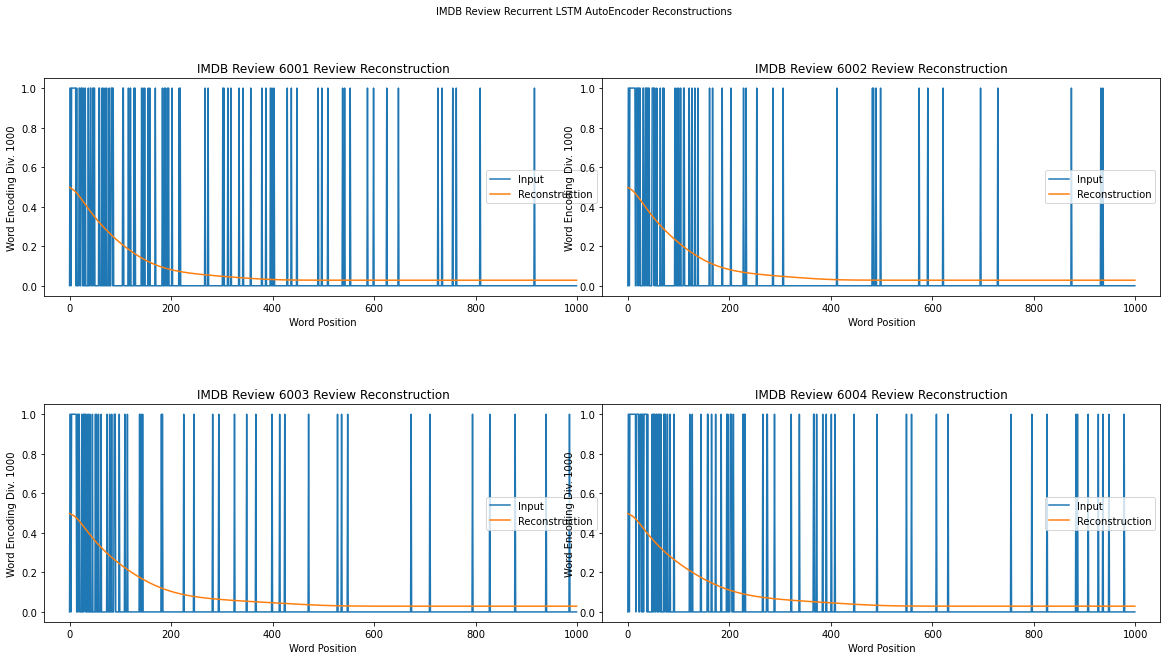

In [27]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
plt.suptitle('IMDB Review Recurrent LSTM AutoEncoder Reconstructions', fontsize=10)
i=6000

for row in ax:
    for col in row:
        X_train_RE_vec_samp = X_Train_RE_vec[i].reshape(1, top_words, 1)
        x_RE_vec_recreate   = recurrent_ae.predict(X_train_RE_vec_samp, verbose=0)
        col.plot(X_train_RE_vec_samp.reshape(top_words))
        col.plot(x_RE_vec_recreate.reshape(top_words))
        col.set_title('IMDB Review '+str(i+1)+' Review Reconstruction')
        col.set_xlabel("Word Position")
        col.set_ylabel('Word Encoding Div. 1000')
        col.legend(['Input', 'Reconstruction'])
        #plt.show()
        i = i + 1

### Plot the training/validation loss and MSE training performance

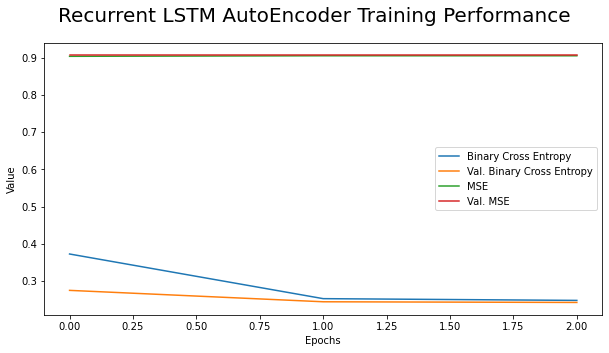

In [29]:
plt.figure(figsize=(10,5))
plt.plot(history_ae['epoch'],history_ae['loss'])
plt.plot(history_ae['epoch'], history_ae['val_loss'])
plt.plot(history_ae['epoch'], history_ae['rounded_accuracy'])
plt.plot(history_ae['epoch'], history_ae['val_rounded_accuracy'])
plt.suptitle('Recurrent LSTM AutoEncoder Training Performance', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(['Binary Cross Entropy', 'Val. Binary Cross Entropy', 'MSE', 'Val. MSE'])
#plt.savefig('RE_Loss_MSE_Training_FINAL.png')

### Visualize the Encoder Compressed IMDB Movie Reviews with t-SNE 

In [23]:
X_Train_RE.shape

(7500, 100, 1)

In [24]:
start_time = time.time() 
X_train_RE_compressed = recurrent_encoder.predict(X_Train_RE)
tsne_Encoder_RE = TSNE(perplexity = 50, n_iter = 4000, learning_rate = 10)
X_train_2D_RE = tsne_Encoder_RE.fit_transform(X_train_RE_compressed)
X_train_2D_RE = (X_train_2D_RE - X_train_2D_RE.min()) / (X_train_2D_RE.max() - X_train_2D_RE.min())
print('---- %s seconds to train t-SNE ----' % (time.time() - start_time))

KeyboardInterrupt: 

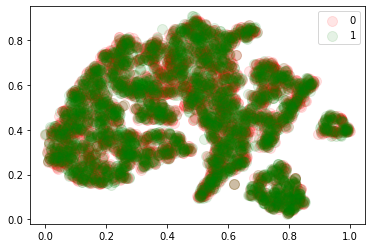

In [22]:
cdict = {0: 'red', 1: 'green'}

fig, ax = plt.subplots()
for g in np.unique(y_Train_RE):
    ix = np.where(y_Train_RE == g)
    ax.scatter(X_train_2D_RE[ix,0], X_train_2D_RE[ix,1], c = cdict[g], label = g, s = 100, alpha = 0.1)
ax.legend()
plt.show()

In [23]:
X_train_2D_RE.shape

(7500, 2)

# Build the sentiment classification dense neural network using the encoder from the Recurrent LSTM Autoencoder.

In [37]:
del Sentiment_clf

In [38]:
recurrent_encoder_clone   = keras.models.clone_model(recurrent_encoder)
# recurrent_encoder_clone = model.layers[i].get_weights()

# Configure the sentiment classification model
Sentiment_clf = keras.models.Sequential([
    recurrent_encoder_clone,
    keras.layers.Flatten(),
    #Dropout(rate=0.2), # Regularize the the model with 20% dropout rate (80% keep probability).
    keras.layers.Dense(64,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add relu activation layer 
    keras.layers.Dense(32,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add relu activation layer 
    keras.layers.Dense(16,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add relu activation layer 
    #Dropout(rate=0.5), # Regularize the final layer with 50% dropout rate.
    keras.layers.Dense(1, activation="sigmoid", kernel_initializer = tf.keras.initializers.GlorotNormal())
])

# Freeze the encoder layer 
Sentiment_clf.layers[0].trainable = True  

#Compile the model.
Sentiment_clf.compile(loss="binary_crossentropy", 
                      optimizer= keras.optimizers.Adam(0.001), # use the standard learning_rate=0.0001
                      metrics=[metrics.binary_accuracy])


# save best parameter estimate using val loss.
checkpointer_se = ModelCheckpoint("Encoder_Sentiment_Model.hdf5", monitor="val_loss", mode="auto",#monitor valid. loss
                                  save_best_only = True, verbose=1)

# early stopping.
#earlystoper_se = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1) # patience is num. epochs wo improv.

# save the training history.
csv_logger_se = CSVLogger('EncoderSM.log', separator=',', append=False) 

# compile the callbacks together
callbackser_se = [checkpointer_se, csv_logger_se]

In [39]:
Sentiment_clf.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 50)                118800    
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)              

# Train the Encoder Sentiment Classifier

In [40]:

#Sentiment_clf.layers[0].get_weights()

In [41]:
start_time = time.time() 
history_se = Sentiment_clf.fit(X_Train_RE_vec, y_Train_RE, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_RE_vec, y_Valid_RE), callbacks = callbackser_se)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.6970 - binary_accuracy: 0.5131
Epoch 00001: val_loss improved from inf to 0.69297, saving model to Encoder_Sentiment_Model.hdf5
150/150 [==============================] - 276s 2s/step - loss: 0.6970 - binary_accuracy: 0.5131 - val_loss: 0.6930 - val_binary_accuracy: 0.5100
Epoch 2/10
 30/150 [=====>........................] - ETA: 3:23 - loss: 0.6928 - binary_accuracy: 0.5013

KeyboardInterrupt: 

In [42]:
y_Train_RE.sum()/7500

0.49333333333333335

In [ ]:
start_time = time.time() 
history_se = Sentiment_clf.fit(X_Train_RE, y_Train_RE, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_RE, y_Valid_RE), callbacks = callbackser_se)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

In [ ]:
# retrieve the best model weights.
Sentiment_clf.load_weights("Encoder_Sentiment_Model.hdf5")

history_se = pd.read_csv('EncoderSM.log', sep=',', engine='python')

In [67]:
y_Train_RE.dtype

dtype('int64')

# Evaluate the Encoder Sentiment Classifier

### Plot the training/validation loss and MSE training performance

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history_ae['loss'])
plt.plot(history_ae['val_loss'])
plt.plot(history_ae['mse'])
plt.plot(history_ae['val_mse'])
plt.suptitle('Encoder Sentiment Classifier Training Performance', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(['Binary Cross Entropy', 'Val. Binary Cross Entropy', 'MSE', 'Val. MSE'])
#plt.savefig('SM_Loss_MSE_Training_FINAL.png')

### Evaluate the test set accuracy.

In [ ]:
# Evaluate the test set.
test_loss, test_acc = Sentiment_clf.evaluate(X_Test, y_Test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))